# Mathematical Models

This notebook develops a few simple mathematical models to forecast the time-series data provided by 'time_series.csv'. The performance of these models, including simple exponential smoothing and polynomial fitting, will serve as a benchmark for the machine learning models.

In [1]:
from temp_utilities import *
from temp_math_scripts import *

## Load the time series

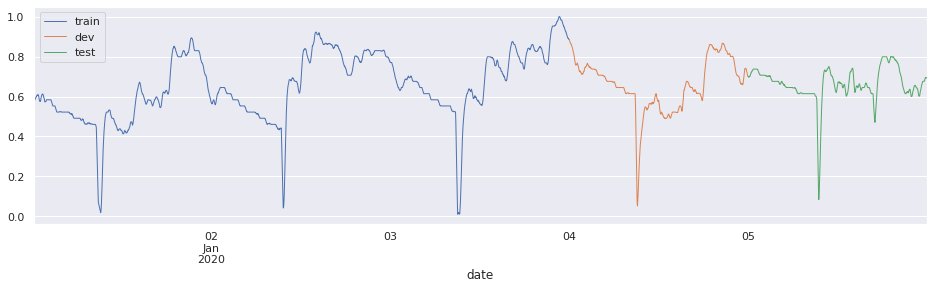

In [2]:
# Load time series data
time_series = pd.read_csv('../input/temp1-data-preparation/time_series.csv', index_col='date').asfreq('T')['temp']

# Chop series for developing
time_series = time_series.loc['2020-01-01':'2020-01-05'] # 5 days

# Normalize the data
min_value = np.min(time_series)
max_value = np.max(time_series)
time_series = (time_series - min_value)/(max_value - min_value)

# Make date strictly positive (required for Holt model)
time_series = (time_series + 0.01)/1.01

def un_normalize_series(series):
    original = series * 1.01 - 0.01
    original = original * (max_value - min_value) + min_value
    return original
    
# Size of dev and test sets (in same units as time_series: minutes)
size_dev = 60 * 24 * 1 # 1 days
size_test = 60 * 24 * 1 # 1 day

# Split time series into train, dev and test sets
time_series_train, time_series_dev, time_series_test = train_dev_test_split(time_series, size_dev, size_test)  # for implementation, see temp-utilities.py

# Plot the time series
plot_time_series(time_series_train, time_series_dev, time_series_test)  # for implementation, see temp-utilities.py

Keep a small subset of the first 100 points in the time series, to be used for illustrating the algorithms below.

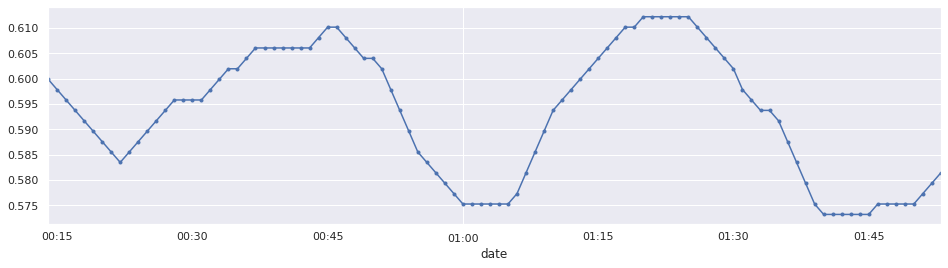

In [3]:
# Subset of the first 100 points
time_series_small = time_series.iloc[:100]
time_series_small.plot(style='.-');

## Model 1: Single Exponential Smoothing

Single Exponential Smoothing allows for forecasting using an exponentially weighted average of the time series.

Given a time series $x_t$ for $t \geq 0$, the smoothened value $S_t$ at times $t > 1$ is calculated recursively by

$$S_{t} = \alpha \, x_{t-1} + (1-\alpha) \, S_{t-1}\,,$$

starting from $S_{1} = x_{0}$. Here, $\alpha \in (0,1)$ is the exponential weighting parameter.

This can be used for forecasting. Suppose that we know the series up until the time $t=T$,

$$x_{0},\, x_{1},\, x_{2},\, \dotsc,\, x_{T-1},\, x_{T}$$

The forecast $\hat{x}_{T+1}$ for next value in the time series is then given by $S_{T+1}$,

\begin{align*}
\hat{x}_{T+1} &= S_{T+1} \\ &= \alpha \, x_T + (1-\alpha) \, S_T
\end{align*}


The typical way to select $\alpha$ is to find the value that minimizes the sum of squared errors

$$\text{SSE}(\alpha) = \sum_{t} (x_t - \hat{x}_{t})^2$$

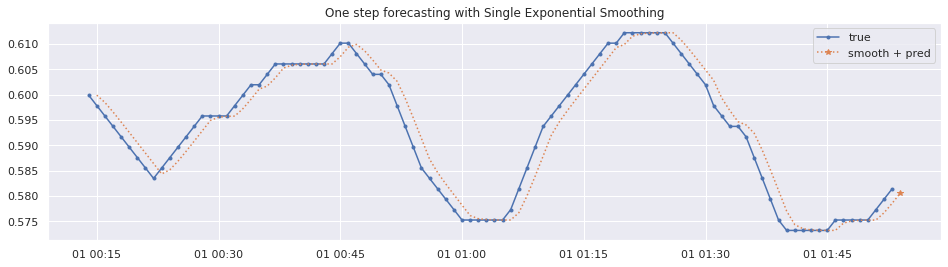

In [4]:
# Single Exponential Smoothing -- one step forecasting
true = time_series_small
pred = SES_one_step(true, alpha = 0.7)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('One step forecasting with Single Exponential Smoothing');
plt.plot(true, '.-', label='true');
plt.plot(pred, '*:', label='smooth + pred', markevery=[-1]);
plt.legend();

The smoothened sequence is shown as an orange dotted line. 
The forecast is the last point in this smooth sequence, indicated with a star.

There are two problems with this model:
1. the forecast value is lower than the last measured value, although the trend was upwards
2. the model does not lend itself to multi-step forecasting

For these reasons we will develop a more sophisticated model next, Double Exponential Smoothing, which takes trend into account.

### Sidenote

Before moving on to the next model, let's elaborate on the second mentioned problem:
this SES model does not lend itself to multi-step forecasting.

Indeed, suppose that we would try multi-step forecasting by augmenting the original series with the forecast for time $T+1$, to obtain

$$x_{0},\, x_{1},\, x_{2},\, \dotsc,\, x_{T-1},\, x_{T},\, \hat{x}_{T+1}$$

But then the last 'true' value and the last forecast are equal. 
As a consequence, the next forecast will be equal to the previous forecast. 
In fact, all subsequent forecasts will be equal: $\hat{x}_{T+k} = \hat{x}_{T+1}$ for all $k>1$. 
This is demonstrated below.

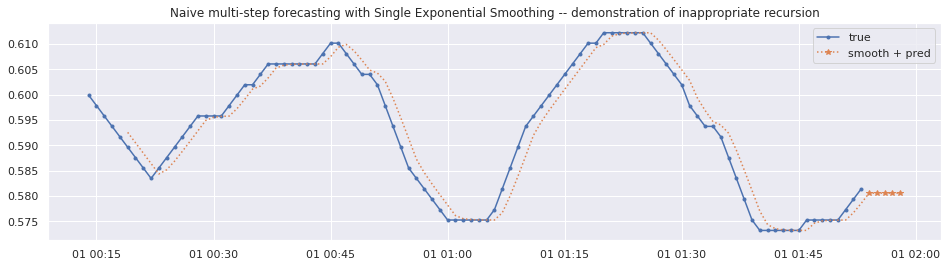

In [5]:
# Single Exponential Smoothing -- naive recursive multi-step forecasting version 1
true = time_series_small
pred = SES_naive_recursion_v1(true, alpha = 0.7, steps = 5)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Naive multi-step forecasting with Single Exponential Smoothing -- demonstration of inappropriate recursion');
plt.plot(true, '.-', label='true');
plt.plot(pred, '*:', label='smooth + pred', markevery=list(np.arange(-5,0)));
plt.legend();

Clearly, such a straight horizontal line does not make for a good multi-step forecast.

Alternatively, suppose that we would try multi-step forecasting as follows. 
Let's replace the whole original series with the smoothened values,

$$S_{1},\, S_{2},\, \dotsc,\, S_{T-1},\, S_{T},\, S_{T+1}$$

Smoothening out these series in turn, introduces primarily an additional lag in the forecast, as demonstrated below.

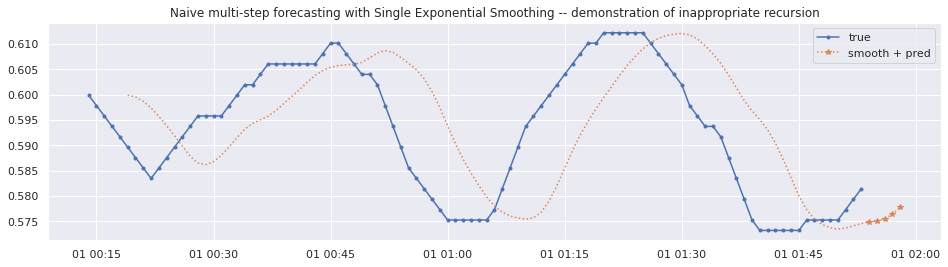

In [6]:
# Single Exponential Smoothing -- naive recursive multi-step forecasting version 2
true = time_series_small
pred = SES_naive_recursion_v2(true, alpha = 0.7, steps = 5)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Naive multi-step forecasting with Single Exponential Smoothing -- demonstration of inappropriate recursion');
plt.plot(true, '.-', label='true');
plt.plot(pred, '*:', label='smooth + pred', markevery=list(np.arange(-5,0)));
plt.legend();

Such a delayed sequence does not make for a good forecast either.

It is better to use a more sophisticated method, such as 'Double Exponential Smoothing' method, as discussed below.

## Model 2: Double Exponential Smoothing

Double Exponential Smoothing allows for forecasting using an exponentially weighted average of a time series with trend.

Given a time series $x_t$ for $t \geq 0$, the smoothened value $S_t$ and smoothened trend $b_t$ at times $t > 0$ are calculated recursively by

\begin{align*}
S_{t} = \alpha \, x_{t} + (1-\alpha) \, (S_{t-1}+ \phi \, b_{t-1})\,, \\
b_{t} = \beta \, (S_{t} - S_{t-1}) + (1-\beta\,) \, \phi \, b_{t-1}\,,
\end{align*}

starting from $S_{0} = x_{0}$ and $b_{0} = x_{1} - x_{0}$. 
Here, $\alpha, \beta \in (0,1)$ are two exponential weighting parameters, while $\phi \in (0,1]$ is an optional parameter that can be used to dampen the impact of the trend.

Suppose that we know the series up until the time $t=T$,

$$x_{0},\, x_{1},\, x_{2},\, \dotsc,\, x_{T-1},\, x_{T}$$

Then the forecast $\widehat{x}_{T+1}$ for next value in the time series is given by the last smoothened value plus the last smoothened trend:

$$\widehat{x}_{T+1} = S_{T} + \phi \, b_{T}$$

The Double Exponential Smoothing method is implemented in statsmodels.tsa.holtwinters.Holt(). 
Optimal values for the parameters are automatically determined by minimizing the sum of squared errors $\text{SSE}(\alpha, \beta, \phi)$.
- The option 'damped=True|False' controls the inclusion of damping by $\phi$. Setting 'damped=False' effectively forces $\phi=1$.
- The option 'exponential=True|False' controls the type of trend. Setting 'exponential=True' assumes that the time series is additive (trend + fluctuations). Setting 'exponential=False' assumes that the time series is multiplicative (trend * fluctuations).

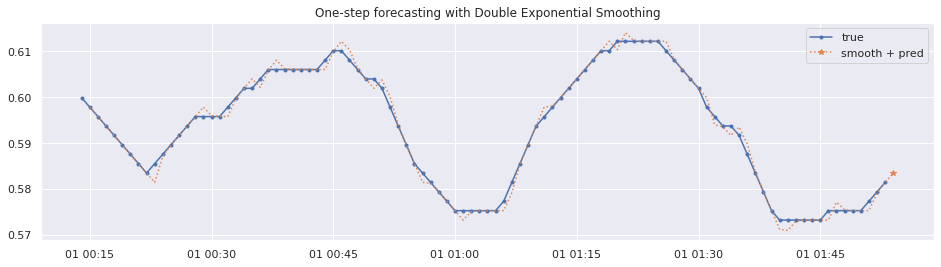

In [7]:
# Double Exponential Smoothing -- one-step forecasting (with optimal values for alpha and beta) without trend damping
true = time_series_small
fit, pred = DES(true, exponential = True, damped = False, steps = 1)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('One-step forecasting with Double Exponential Smoothing');
plt.plot(true, '.-', label='true');
plt.plot(pred, '*:', label='smooth + pred', markevery=[-1]);
plt.legend();

A multi-step forecast is $\hat{x}_{T+\Delta T}$ is also possible, by linear extrapolation using the last known trend:

$$\hat{x}_{T+\Delta T} = S_{T} + \left(\sum_{k=1}^{\Delta T} \phi^k \right) b_{T}$$

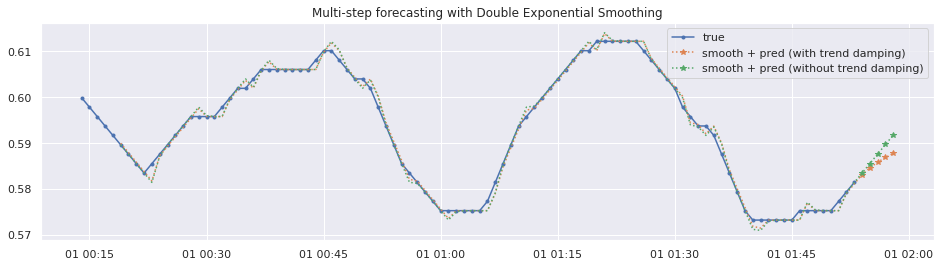

In [8]:
# Double Exponential Smoothing -- multi-step forecasting (with optimal values for alpha, beta and phi)
true = time_series_small

# with trend damping
fit1, pred1 = DES(true, exponential = True, damped = True, steps = 5)  # for implementation, see temp-math-scripts.py

# without trend damping
fit2, pred2 = DES(true, exponential = True, damped = False, steps = 5)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Multi-step forecasting with Double Exponential Smoothing');
plt.plot(true, '.-', label='true');
plt.plot(pred1, '*:', label='smooth + pred (with trend damping)', markevery=list(np.arange(-5,0)));
plt.plot(pred2, '*:', label='smooth + pred (without trend damping)', markevery=list(np.arange(-5,0)));
plt.legend(loc='upper right');

Note how the orange forecast curves downward due to the trend damping as a result of $\phi < 1$.

In fact, let's compare the best-fit parameters:

In [9]:
# Report fit parameters
results = pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$","SSE"])
params = ['smoothing_level','smoothing_slope','damping_slope']
results["DES with damping"] = [fit1.params[p] for p in params] + [fit1.sse]
results["DES without damping"] = [fit2.params[p] for p in params] + [fit2.sse]
results

,DES with damping,DES without damping
$\alpha$,1.000000,1.000000
$\beta$,0.982028,0.894780
$\phi$,0.842116,NaN
SSE,0.000132,0.000143


These parameters are choses such as to minimise the sum of squared errors $\text{SSE}(\alpha, \beta, \phi)$ for times $t=1,\dotsc,T$, which finds the best fit to the known values. 

For our purpose of forecasting, it will be more interesting to measure the error of the forecasts at times $t = T+1, \dotsc, T+\Delta T$.
That will be discussed below when evaluating forecasting models. 
But first we consider one more model: polynomial fitting.

## Model 3: Polynomial Fit

The idea of the third model is to fit a polynomial of degree $D$ to the last $N$ points in the time series.
The polynomial can then be used to forecast $\Delta T$ steps ahead.
Schematically,

$$
\begin{align*}
\text{PolyFit}(x_{T-(N-1)}, \dotsc, x_{T}) \,\,\rightarrow\,\, f(t) = c_0 + c_1 t + \dotsc + c_D t^D &\,\,\rightarrow\,\, \hat{x}_{T+1} = f(T+1)\,,\\ &\,\,\,\,\vdots\\ &\,\,\rightarrow\,\, \hat{x}_{T+\Delta T} = f(T+\Delta T)\,.
\end{align*}
$$

The degree $D>0$ and number of points $N>D$ are adjustable parameters in the model.
Polynomial fitting is implemented in numpy.polyfit().

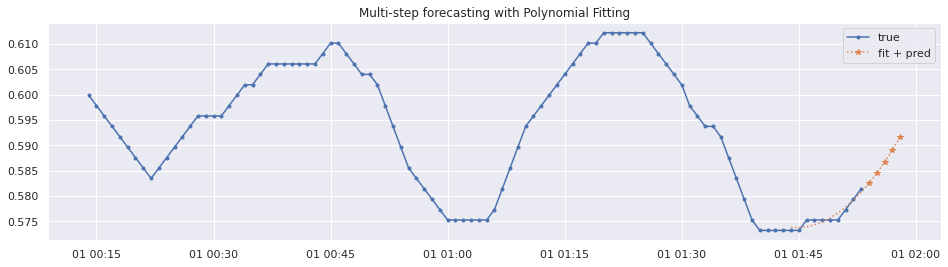

In [10]:
# PolyFit -- multi-step forecasting
true = time_series_small
pred = PolyFit(true, points = 10, degree = 2, steps = 5)  # for implementation, see temp-math-scripts.py

sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Multi-step forecasting with Polynomial Fitting');
plt.plot(true, '.-', label='true');
plt.plot(pred, '*:', label='fit + pred', markevery=list(np.arange(-5,0)));
plt.legend();

This model is simple and has only a few parameters: points and degree.
It will be interesting to compare its performance to the DES model.

## Evaluate forecasting model performance

To evaluate the model performance, we proceed as follows.

Initialize the fit windows and forecast windows:
- Fit window: the last 'fit_window_size' points in the train set. 
- Forecast window: the first 'forecast_window_size' points in the dev set.

Compute the forecast error:
- Fit the model to the points in the fit window. 
- Use the model to forecast the points in the forecast window.
- Compute the root mean squared error (RMSE) for all points in the forecast compared to the corresponding 'true' values.

Shift both windows by one time step and repeat the last three steps.

The initial fit and forecast windows are illustrated below.

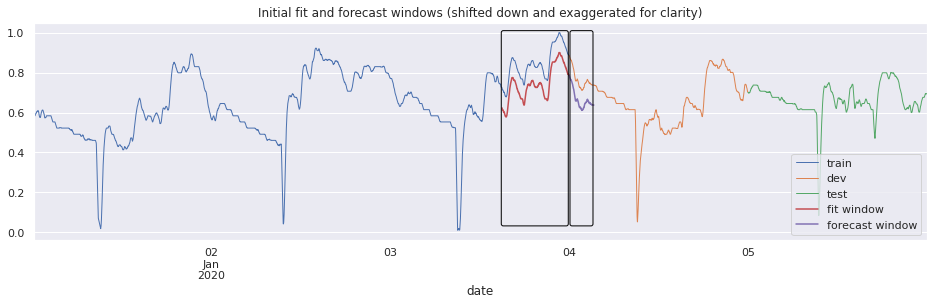

In [11]:
# Extract an evaluation window
evaluation_set = time_series.iloc[60*24*2: 60*24*4]

# Plot the evaluation set and initial fit/forecast windows
plot_time_series(time_series_train, time_series_dev, time_series_test)
plt.title('Initial fit and forecast windows (shifted down and exaggerated for clarity)');
(time_series_train[-540:]-0.1).plot(label='fit window');
(time_series_dev[:200]-0.1).plot(label='forecast window');
plt.text(time_series_train.index[-23], 1.0, '\n\n                              ',
         {'color': 'black', 'fontsize': 20, 'ha': 'right', 'va': 'top', 'rotation': 90,
          'bbox': dict(boxstyle="round", fc="none", ec="black", pad=0.1)})
plt.text(time_series_dev.index[23], 1.0, '                              ', 
         {'color': 'black', 'fontsize': 20, 'ha': 'left', 'va': 'top', 'rotation': 90,
          'bbox': dict(boxstyle="round", fc="none", ec="black", pad=0.1)})
plt.legend();

The initial forecast and its error is computed below.

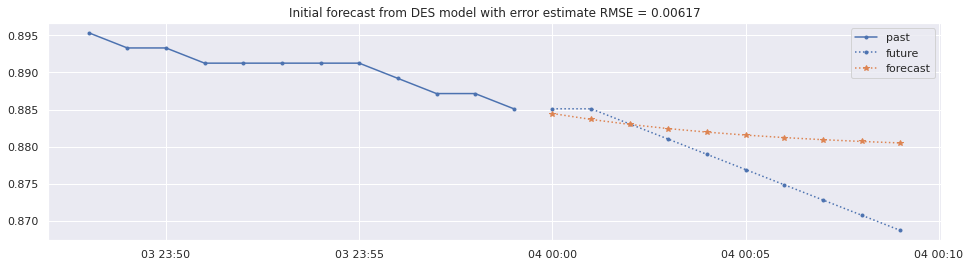

In [12]:
# Illustration: Compute error of initial forecast in DES model
fit_window_size = 12
forecast_window_size = 10

# Extract the set to fit from end of training set
fit_set = time_series.loc[:time_series_dev.index[0]][-fit_window_size-1:-1]
# Predict the next 'forecast_window_size' steps in the series
_, pred = DES(fit_set, exponential = True, damped = True, steps = forecast_window_size)
pred = pred[-forecast_window_size:]
# Compute the error against the true values in the dev set
error = RMSE(time_series_dev, pred)

# Plot the past, future and forecast
sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Initial forecast from DES model with error estimate RMSE = {:.5f}'.format(error));
past, = plt.plot(fit_set, '.-', label='past');
plt.plot(time_series_dev[:forecast_window_size], '.:', label='future', color = past.get_color());
plt.plot(pred, '*:', label='forecast', markevery=list(np.arange(-forecast_window_size,0)));
plt.legend();

The second forecast and its error is computed below, by shifting the windows one time step.

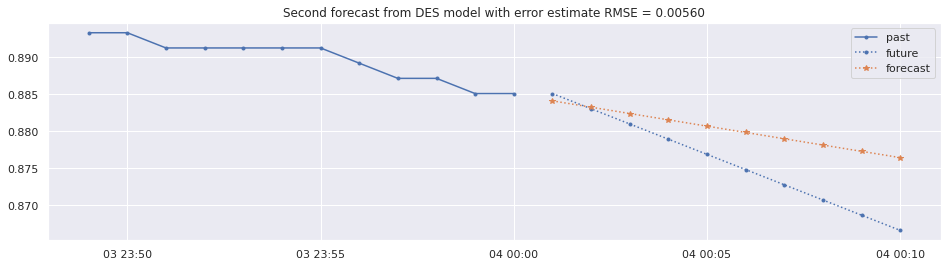

In [13]:
# Illustration: Compute error of next forecast in DES model
fit_window_size = 12
forecast_window_size = 10
shift = 1

# Extract the set to fit from end of training set
fit_set = time_series.loc[:time_series_dev.index[shift]][-fit_window_size-1:-1]
# Predict the next 'forecast_window_size' steps in the series
_, pred = DES(fit_set, exponential = True, damped = True, steps = forecast_window_size)
pred = pred[-forecast_window_size:]
# Compute the error against the true values in the dev set
error = RMSE(time_series_dev, pred)

# Plot the past, future and forecast
sns.set(rc={'figure.figsize':(16, 4)})
plt.title('Second forecast from DES model with error estimate RMSE = {:.5f}'.format(error));
past, = plt.plot(fit_set, '.-', label='past');
plt.plot(time_series_dev[shift:forecast_window_size+shift], '.:', label='future', color = past.get_color());
plt.plot(pred, '*:', label='forecast', markevery=list(np.arange(-forecast_window_size,0)));
plt.legend();

Repeating this process, we can compute the errors for all forecasts.

It will actually be more informative to acquire the error over all forecasts **for fixed forecasting depth**.
In other words, obtain one RMSE error for all one-step forecasts, one RMSE error for all two-step forecasts, and so on.

This is done below for three selected models.

In [14]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
fit_window_size = 20            # for DES: fit model to last 20 points
points = 5                      # for PolyFit: fit model to last 5 points
degree = 2                      # for PolyFit: fit quadratic polynomial
history = time_series_train     # use train set as history
future = time_series_dev        # use dev set as future


# Initialize arrays for results
details = ['']*3
errors = [0]*3

# Compute errors in a DES model
details[0], errors[0], _ = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                    fit_window_size = fit_window_size, 
                                    forecast_window_size = forecast_window_size,
                                    model = 'DES', parameters = {'exponential':True, 'damped':True})
# Compute errors in another DES model
details[1], errors[1], _ = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                    fit_window_size = fit_window_size, 
                                    forecast_window_size = forecast_window_size,
                                    model = 'DES', parameters = {'exponential':True, 'damped':False})
# Compute errors in a PolyFit model
details[2], errors[2], _ = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                    fit_window_size = points+forecast_window_size+1, 
                                    forecast_window_size = forecast_window_size,
                                    model = 'PolyFit', parameters = {'points':points, 'degree':degree})
                                    # Note that the role of 'fit_window_size' is played by 'points'

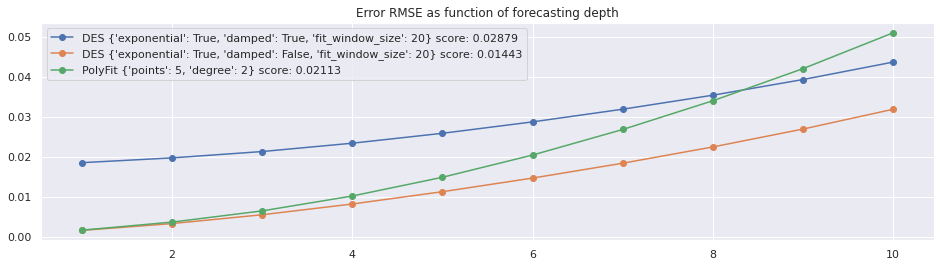

In [15]:
# Plot the errors as a function of the forecasting depth
plt.title('Error RMSE as function of forecasting depth');
for i in range(3):
    score = np.mean(errors[i]) # Score each model by the mean error over all forecast depths
    plt.plot(np.arange(1,forecast_window_size+1), errors[i], 'o-', label=details[i]+' score: {:.5f}'.format(score));
plt.legend();

Analysis of preliminary results: 
- The RMSE increases with the forecasting depth for all models, as one would expect from a decreased correlation between measured valued separated further in time. Given typical (normalized) measurements in the range (0.4, 0.8), the lowest RMSE error of 0.03 at ten-step forecast, is equivalent to a 7.5% error on the forecast.
- The two DES models exhibit similar trends, albeit shifted by a constant. The shift must be due to the difference in damping, although it is not entirely clear exactly why this happens.
- The PolyFit model is good for forecasting a few steps ahead, but shows worse behaviour than the DES models at large forecasting depth. This is not surprising from a second degree polynomial fit.

## Grid search forecasting models

We have not (explicitly) motivated the values for the parameters

- fit_window_size (for DES)
- exponential (for DES)
- damped (for DES)
- points (for PolyFit)
- degree (for PolyFit)

other than setting reasonable values.

Here we run a grid search to find the combinations of parameters that leads to the best score (average error over forecasting depths). 
Lower score = better!

In [16]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
history = time_series_train     # use train set as history
future = time_series_dev        # use dev set as future

# Initialize arrays for results
details_list = []
errors_list = []

# Loop over ranges of parameters for DES
for fit_window_size in np.array([2,4,6,8,10,12]) * forecast_window_size:
    for exp in [True,False]:
        for damp in [True,False]:
            #print('                  DES:',[fit_window_size,exp,damp], end='\r')
            det, err, _ = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                   fit_window_size = fit_window_size, 
                                   forecast_window_size = forecast_window_size,
                                   model = 'DES', parameters = {'exponential':exp, 'damped':damp})
            details_list.append(det)
            errors_list.append(err)

# Loop over ranges of parameters for PolyFit
for degree in np.array([1,2,3,4,5]):
    for points in np.array([2,4,6,8,10,12,14,16,18,20]):
        if points > degree:
            #print('                  PolyFit:',[degree,points], end='\r')
            det, err, _ = Forecast(history, future,
                                   fit_window_size = points+forecast_window_size+1, 
                                   forecast_window_size = forecast_window_size,
                                   model = 'PolyFit', parameters = {'points':points, 'degree':degree})
            details_list.append(det)
            errors_list.append(err)

Visualize the results from the grid search and select the best model.

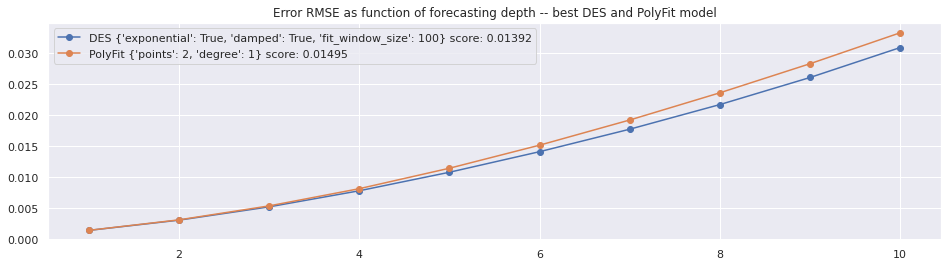

In [17]:
# Collect result in a table
table = pd.DataFrame(columns=['details','errors','score'])
table['details'] = details_list
table['errors'] = errors_list
table['score'] = np.mean(errors_list, axis=1)
table = table.sort_values('score')

# Plot the errors of the best DES and best PolyFit models as a function of the forecasting depth
best1 = np.array(table.where(table['details'].apply(lambda s:s[0:3]) == 'DES').dropna()[0:1])[0]
best2 = np.array(table.where(table['details'].apply(lambda s:s[0:3]) == 'Pol').dropna()[0:1])[0]

plt.title('Error RMSE as function of forecasting depth -- best DES and PolyFit model');
plt.plot(np.arange(1,forecast_window_size+1), best1[1], 'o-', label=best1[0]+' score: {:.5f}'.format(best1[2]));
plt.plot(np.arange(1,forecast_window_size+1), best2[1], 'o-', label=best2[0]+' score: {:.5f}'.format(best2[2]));
plt.legend();

The DES model performs only marginally better than a linear extrapolation from the last two measurements, but its error scales better with forecasting depth.

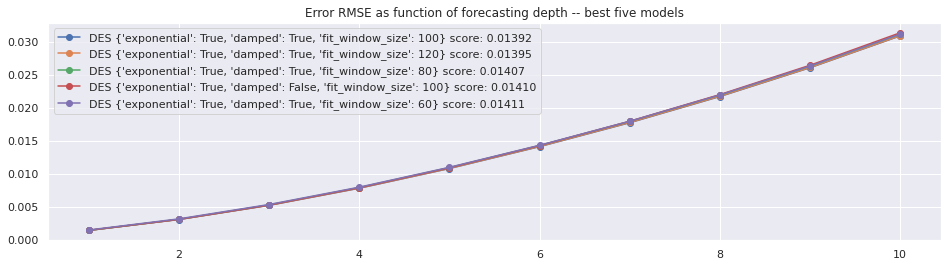

In [18]:
# Plot the errors of the overall top 5 models as a function of the forecasting depth
plt.title('Error RMSE as function of forecasting depth -- best five models');
for i in range(min(5,len(table))):
    det = table.iloc[i,0]
    err = table.iloc[i,1]
    sco = table.iloc[i,2]
    plt.plot(np.arange(1,forecast_window_size+1), err, 'o-', label=det+' score: {:.5f}'.format(sco));
plt.legend();

The best model is: **DES with {'exponential':True, 'damped':True, 'fit_window_size':100}**

Below is a demonstration of forecasting with this model.

## Demonstrate best model forecast

Fit the best model on the dev set and forecast on the test set.

In [19]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
fit_window_size = 100           # fit the last 100 values
exponential = True              # additive time series 
damped = True                   # dampen the trend impact on forecast
history = time_series_dev       # use dev set as history
future = time_series_test       # use test set as future

# Forecasting
details, errors, forecast = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                     fit_window_size = fit_window_size, 
                                     forecast_window_size = forecast_window_size,
                                     model = 'DES', parameters = {'exponential':exponential, 'damped':damped})

# Un-normalize the series to show degree Centigrade on the y-axis
history = un_normalize_series(history)
forecast = un_normalize_series(forecast)

Demonstrate the model forecasting in two qualitatively different ranges in the test set.

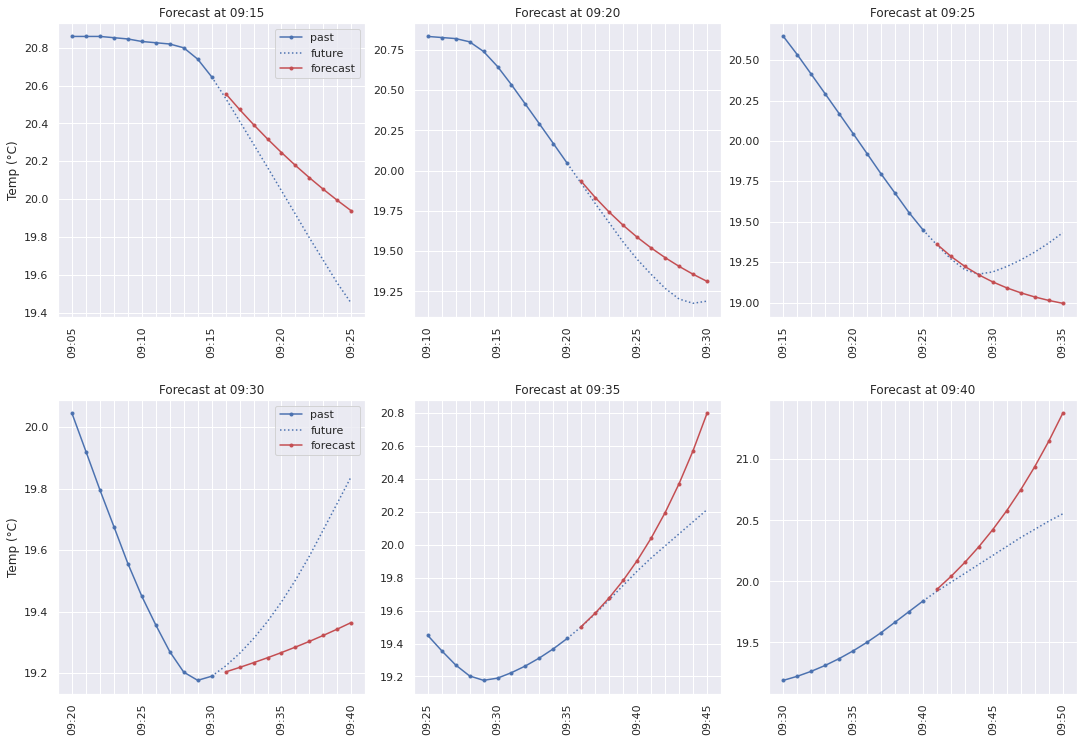

In [20]:
# Forecasting in a valley
Demonstration(history, forecast, cols=3, rows=2, start=557, step=5)

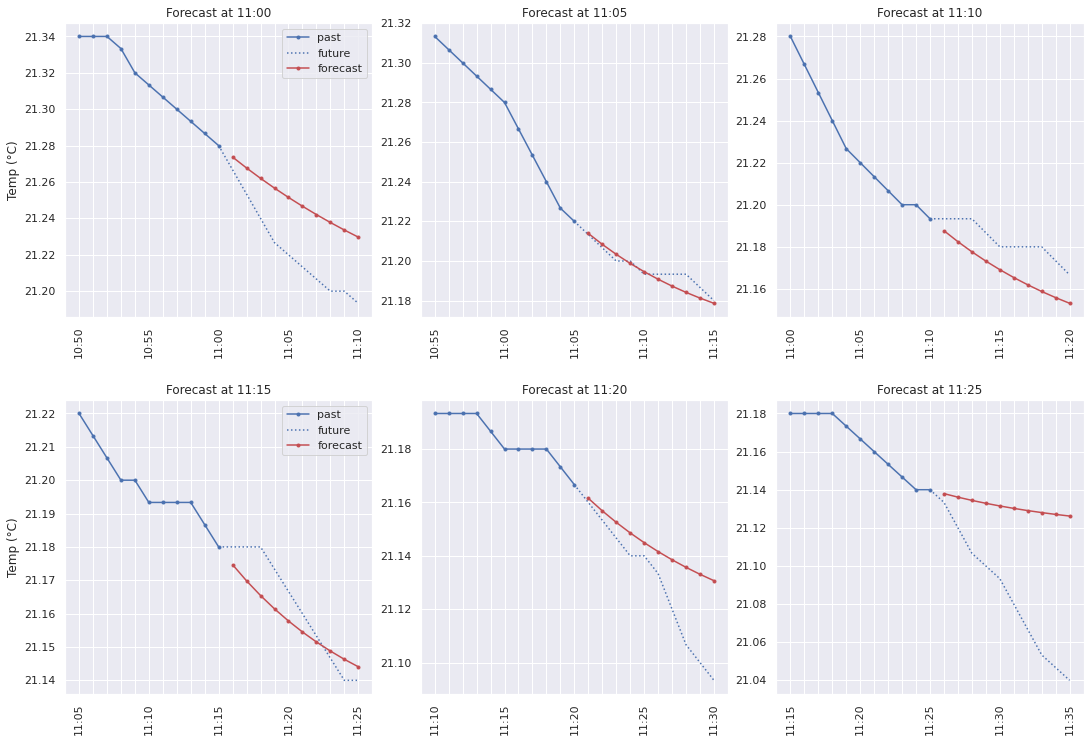

In [21]:
# Forecasting on a bumpy downhill slope
Demonstration(history, forecast, cols=3, rows=2, start=662, step=5)

Demonstration of forecasting in practice, when no future data is known.
In this case, fit the best model on the test set and perform one multi-step forecast beyond the test set.

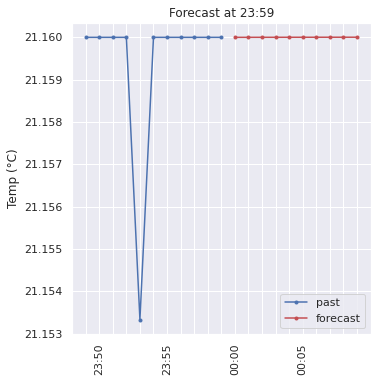

In [22]:
# Set parameters
forecast_window_size = 10       # forecast 10 steps ahead
fit_window_size = 100           # fit the last 100 values
exponential = True              # additive time series 
damped = True                   # dampen the trend impact on forecast
history = time_series_test      # use test set as history
future = None                   # no future values known

# Forecasting
details, errors, forecast = Forecast(history, future,  # for implementation of Forecast(), see temp-math-scripts.py
                                     fit_window_size = fit_window_size, forecast_window_size = forecast_window_size,
                                     model = 'DES', parameters = {'exponential':exponential, 'damped':damped})

# Un-normalize the series to show degree Centigrade on the y-axis
history = un_normalize_series(history)
forecast = un_normalize_series(forecast)

# One multi-step forecast beyond last measurement
Demonstration(history, forecast)